In [10]:
import sys
sys.path.append('..')

# OS and system
import os
import gc
import argparse
from argparse import Namespace
import pickle

# utils
from functools import partial
from copy import deepcopy
from tqdm import tqdm
import time

# mathematics
import matplotlib.pyplot as plt
import numpy as np
import random

# data handling
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision

# logging
# import wandb

# my_lib
from model.net import *
from model.train import train, test
from misc.utils import save_checkpoint, load_transform, load_dataset


In [11]:
random_train_logs = {}
random_test_logs = {}

model_name = 'vcnn_m0'

perturb_eps = [0.0, 0.0001, 0.001, 0.01]
for eps in perturb_eps:

    # Load the data
    train_temp = []
    test_temp = []
    for seed in range(1, 4):
        train_data = pd.read_csv(f'../results/cifar10/{model_name}/PGD_random_none/eps_{eps}/seed_{seed}/train_log.csv')
        test_data = pd.read_csv(f'../results/cifar10/{model_name}/PGD_random_none/eps_{eps}/seed_{seed}/test_log.csv')

        train_temp.append(train_data)
        test_temp.append(test_data)

    random_train_logs[eps] = train_temp
    random_test_logs[eps] = test_temp



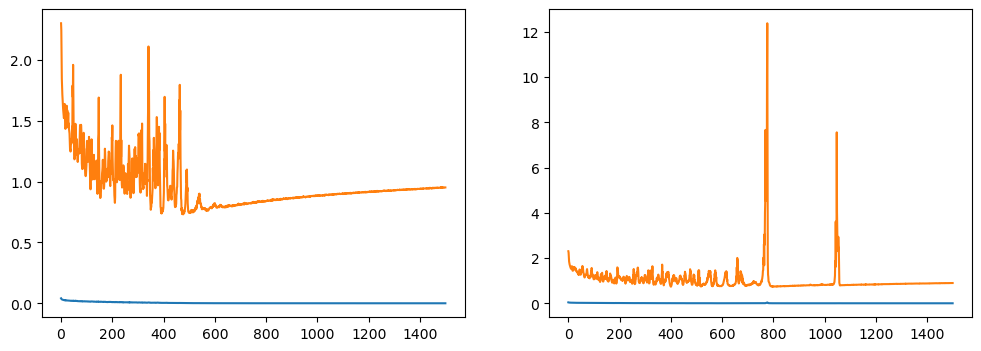

In [12]:
idx = 1
eps = 0.001

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(random_train_logs[0.0][idx]['loss'])
axs[0].plot(random_test_logs[0.0][idx]['loss'])

axs[1].plot(random_train_logs[eps][idx]['loss'])
axs[1].plot(random_test_logs[eps][idx]['loss'])


eps: 0.0 max test acc:  77.85
eps: 0.01 max test acc:  71.67


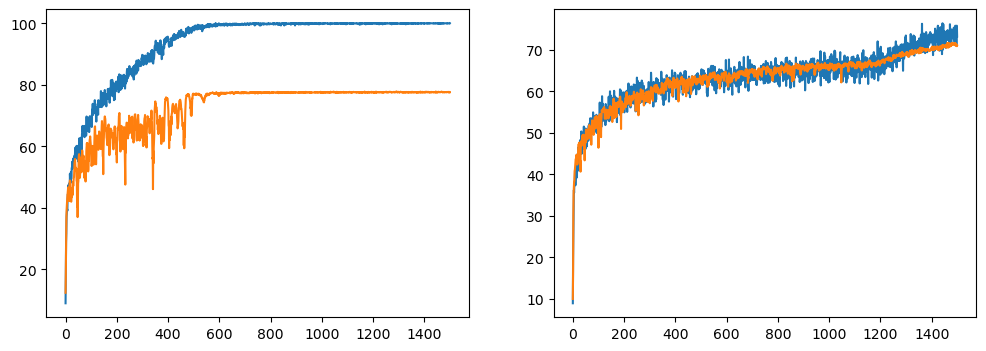

In [15]:
seed = 1
eps = 0.01

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(random_train_logs[0.0][idx]['acc'])
axs[0].plot(random_test_logs[0.0][idx]['acc'])

axs[1].plot(random_train_logs[eps][idx]['acc'])
axs[1].plot(random_test_logs[eps][idx]['acc'])

print('eps: 0.0 max test acc: ', max(random_test_logs[0.0][idx]['acc']))
print(f'eps: {eps} max test acc: ', max(random_test_logs[eps][idx]['acc']))

In [16]:
random_avg_test_accs = {}

for eps in perturb_eps:
    random_avg_test_accs[eps] = []
    for seed in range(3):
        random_avg_test_accs[eps].append(np.mean(random_test_logs[eps][seed]['acc'][-20:]))

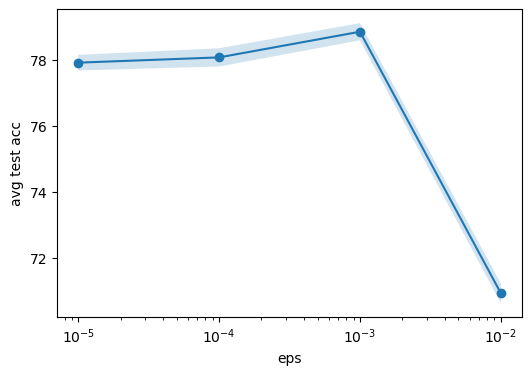

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

perturb_eps = [0.0, 0.0001, 0.001, 0.01]

x_axis = [1e-5] + perturb_eps[1:]
y_axis = [np.mean(random_avg_test_accs[eps]) for eps in perturb_eps]
y_axis_std = [np.std(random_avg_test_accs[eps]) for eps in perturb_eps]

ax.plot(x_axis, y_axis, marker='o', label='avg test accs')  
ax.fill_between(x_axis, np.array(y_axis) - np.array(y_axis_std), np.array(y_axis) + np.array(y_axis_std), alpha=0.2)
ax.set_xlabel('eps')
ax.set_ylabel('avg test acc')

# ax.set_ylim(75, 48)
ax.set_xscale('log')

In [24]:
anti_train_logs = {}
anti_test_logs = {}

perturb_eps = [0.001, 0.01]
perturb_taus = [5e-2, 1e-1, 5e-1, 1, 5]
for eps in perturb_eps:
    anti_train_logs[eps] = {}
    anti_test_logs[eps] = {}

    for tau in perturb_taus:
        # Load the data
        train_temp = []
        test_temp = []
        for seed in range(1, 4):
            train_data = pd.read_csv(f'../results/cifar10/{model_name}/PGD_anti_none/eps_{eps}/tau_{tau}/seed_{seed}/train_log.csv')
            test_data = pd.read_csv(f'../results/cifar10/{model_name}/PGD_anti_none/eps_{eps}/tau_{tau}/seed_{seed}/test_log.csv')

            train_temp.append(train_data)
            test_temp.append(test_data)

        anti_train_logs[eps][tau] = train_temp
        anti_test_logs[eps][tau] = test_temp



(0.0, 4.0)

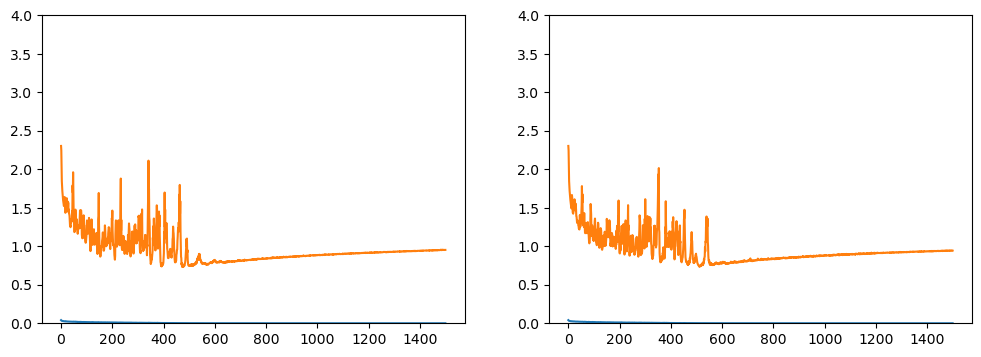

In [25]:
idx = 1
eps = 0.001
tau = 0.5

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(random_train_logs[0.0][idx]['loss'])
axs[0].plot(random_test_logs[0.0][idx]['loss'])

axs[1].plot(anti_train_logs[eps][tau][idx]['loss'])
axs[1].plot(anti_test_logs[eps][tau][idx]['loss'])

axs[0].set_ylim(0, 4)
axs[1].set_ylim(0, 4)


eps: 0.0 max test acc:  78.409996
eps: 0.001 max test acc:  78.579994


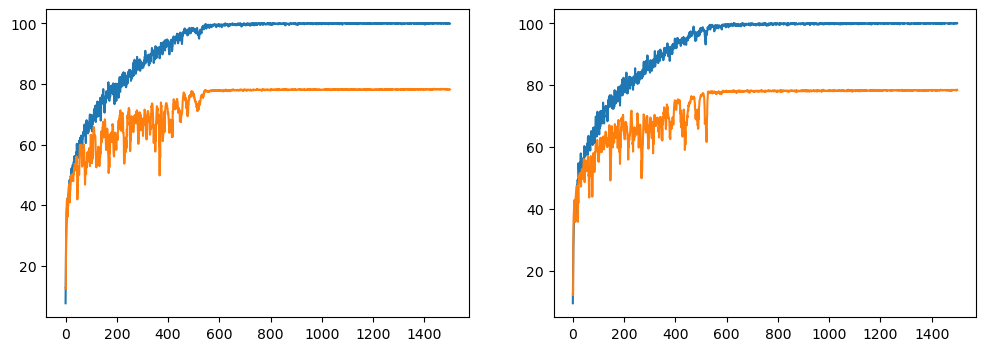

In [26]:
idx = 0
eps = 0.001
tau = 0.05

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(random_train_logs[0.0][idx]['acc'])
axs[0].plot(random_test_logs[0.0][idx]['acc'])

axs[1].plot(anti_train_logs[eps][tau][idx]['acc'])
axs[1].plot(anti_test_logs[eps][tau][idx]['acc'])

print('eps: 0.0 max test acc: ', max(random_test_logs[0.0][idx]['acc']))
print(f'eps: {eps} max test acc: ', max(anti_test_logs[eps][tau][idx]['acc']))

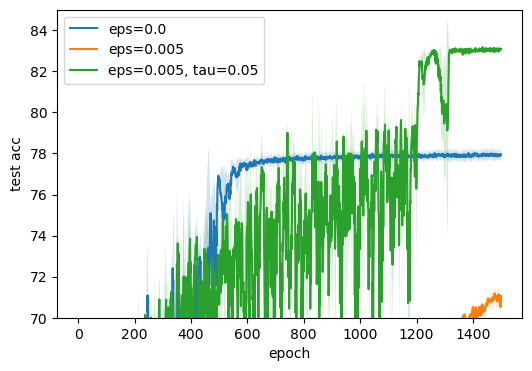

In [47]:
idx = 0
eps = 0.01
tau = 5e-1

perturb_taus = [5e-2, 1e-1, 5e-1, 1, 5]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

res0 = np.array([random_test_logs[0.0][i]['acc'] for i in range(3)])
res1 = np.array([random_test_logs[0.01][i]['acc'] for i in range(3)])
res2 = np.array([anti_test_logs[0.01][tau][i]['acc'] for i in range(3)])

ax.plot(res0.mean(axis=0), label='eps=0.0')
ax.fill_between(range(len(res0.mean(axis=0))), res0.mean(axis=0) - res0.std(axis=0), res0.mean(axis=0) + res0.std(axis=0), alpha=0.2)
ax.plot(res1.mean(axis=0), label='eps=0.005')
ax.fill_between(range(len(res1.mean(axis=0))), res1.mean(axis=0) - res1.std(axis=0), res1.mean(axis=0) + res1.std(axis=0), alpha=0.2)
ax.plot(res2.mean(axis=0), label='eps=0.005, tau=0.05')
ax.fill_between(range(len(res2.mean(axis=0))), res2.mean(axis=0) - res2.std(axis=0), res2.mean(axis=0) + res2.std(axis=0), alpha=0.2)

ax.set_ylim(70, 85)
ax.set_xlabel('epoch')
ax.set_ylabel('test acc')
ax.legend()
# ax.plot(random_test_logs[0.0][idx]['acc'])
# ax.plot(random_test_logs[0.05][idx]['acc'])
# ax.plot(anti_test_logs[0.005][tau][idx]['acc'])
# ax.plot(anti_test_logs[0.05][tau][idx]['acc'])


In [ ]:
anti_max_test_accs = {}

for eps in perturb_eps:
    res_temp = []
    for tau in perturb_taus:
        max_test_acc = 0.0
        temp = []
        for idx in range(3):
            temp.append(max(max_test_acc, max(anti_test_logs[eps][tau][idx]['acc'])))
        res_temp.append(np.mean(temp))

    anti_max_test_accs[eps] = res_temp

In [37]:
anti_avg_test_accs = {}

for eps in perturb_eps:
    anti_avg_test_accs[eps] = {}
    for tau in perturb_taus:
        anti_avg_test_accs[eps][tau] = []
        for seed in range(3):
            anti_avg_test_accs[eps][tau].append(np.mean(anti_test_logs[eps][tau][seed]['acc'][-20:]))

(-0.001, 0.01)

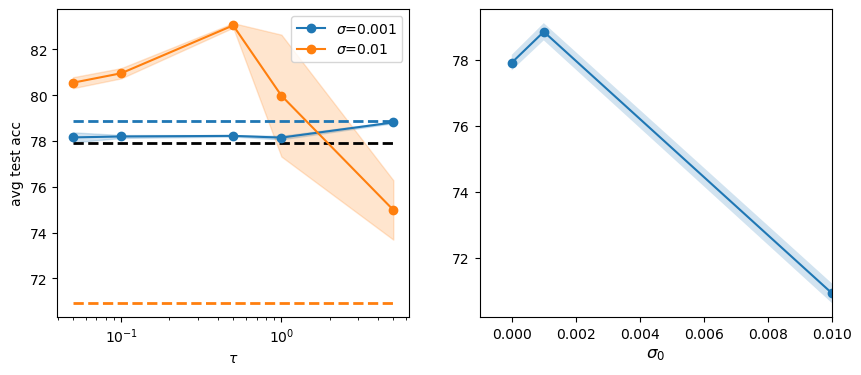

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

perturb_eps = [0.001, 0.01]
perturb_taus = [5e-2, 1e-1, 5e-1, 1, 5]

x_axis = perturb_taus

axs[0].plot(x_axis, np.mean(random_avg_test_accs[0.0]) * np.ones_like(x_axis), 'k--', lw=2.0)
for eps in [0.001, 0.01]:
    color_name = 'C' + str(perturb_eps.index(eps))
    axs[0].plot(x_axis, np.mean(random_avg_test_accs[eps]) * np.ones_like(x_axis), '--', color=color_name, lw=2.0,)

    y_axis = [np.mean(anti_avg_test_accs[eps][tau]) for tau in perturb_taus]
    y_axis_std = [np.std(anti_avg_test_accs[eps][tau]) for tau in perturb_taus]

    axs[0].plot(x_axis, y_axis, color=color_name, marker='o', label=f'$\sigma$={eps}')  
    axs[0].fill_between(x_axis, np.array(y_axis) - np.array(y_axis_std), np.array(y_axis) + np.array(y_axis_std), color=color_name, alpha=0.2)

# axs[0].set_ylim(74, 85)
axs[1].set_ylim(74, 85)
# ax.set_xscale('log')
axs[0].set_xlabel('$\\tau$')
axs[0].set_ylabel('avg test acc')

axs[0].legend()

axs[0].set_xscale('log')


perturb_eps = [0.0, 0.001, 0.01]

x_axis = perturb_eps
y_axis = [np.mean(random_avg_test_accs[eps]) for eps in perturb_eps]
y_axis_std = [np.std(random_avg_test_accs[eps]) for eps in perturb_eps]

axs[1].plot(x_axis, y_axis, marker='o', label='avg test accs')  
axs[1].fill_between(x_axis, np.array(y_axis) - np.array(y_axis_std), np.array(y_axis) + np.array(y_axis_std), alpha=0.2)
axs[1].set_xlabel('$\sigma_0$', fontsize=12)
axs[1].set_xlim(-0.001, 0.01)
# axs[1].set_ylabel('avg test acc', fontsize=12)




In [50]:
np.mean(random_avg_test_accs[eps])

70.9188321